## Pull list of minimarket

To do this, we are using [osmnx](https://osmnx.readthedocs.io/en/stable/getting-started.html) library, which simplify the query process to the OpenStreetMap database, and we got a tidy GeoDataFrame ready to process further.

In [1]:
import osmnx as ox

# Define the area - using Jakarta's bounding box
bbox = (106.6894, -6.3697, 106.9755, -6.1297)  # (west, south, east, north)

alfamart_tags = {'brand': 'Alfamart'}
alfamart = ox.features.features_from_bbox(bbox, tags=alfamart_tags)

indomaret_tags = {'brand': 'Indomaret'}
indomaret = ox.features.features_from_bbox(bbox, tags=indomaret_tags)

# Print the number of Alfamart and Indomaret locations
print(f"Number of Alfamart: {len(alfamart)}")
print(f"Number of Indomaret: {len(indomaret)}")


Number of Alfamart: 305
Number of Indomaret: 413


Next, we convert the OSM data into GeoDataFrames. This will make it easier for us to plot the data on a map.

In [3]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd

alfamart_points = gpd.GeoDataFrame(
    geometry=[Point(geom.centroid.xy) for geom in alfamart.geometry],
    crs=alfamart.crs
)
alfamart_points['type'] = 'Alfamart'

indomaret_points = gpd.GeoDataFrame(
    geometry=[Point(geom.centroid.xy) for geom in indomaret.geometry],
    crs=indomaret.crs
)
indomaret_points['type'] = 'Indomaret'

# Combine the data
all_points = pd.concat([alfamart_points, indomaret_points])


## Plotting the data

Now, we can plot the data on a map. We will use `contextily` to add the basemap, and `matplotlib` to plot the data.

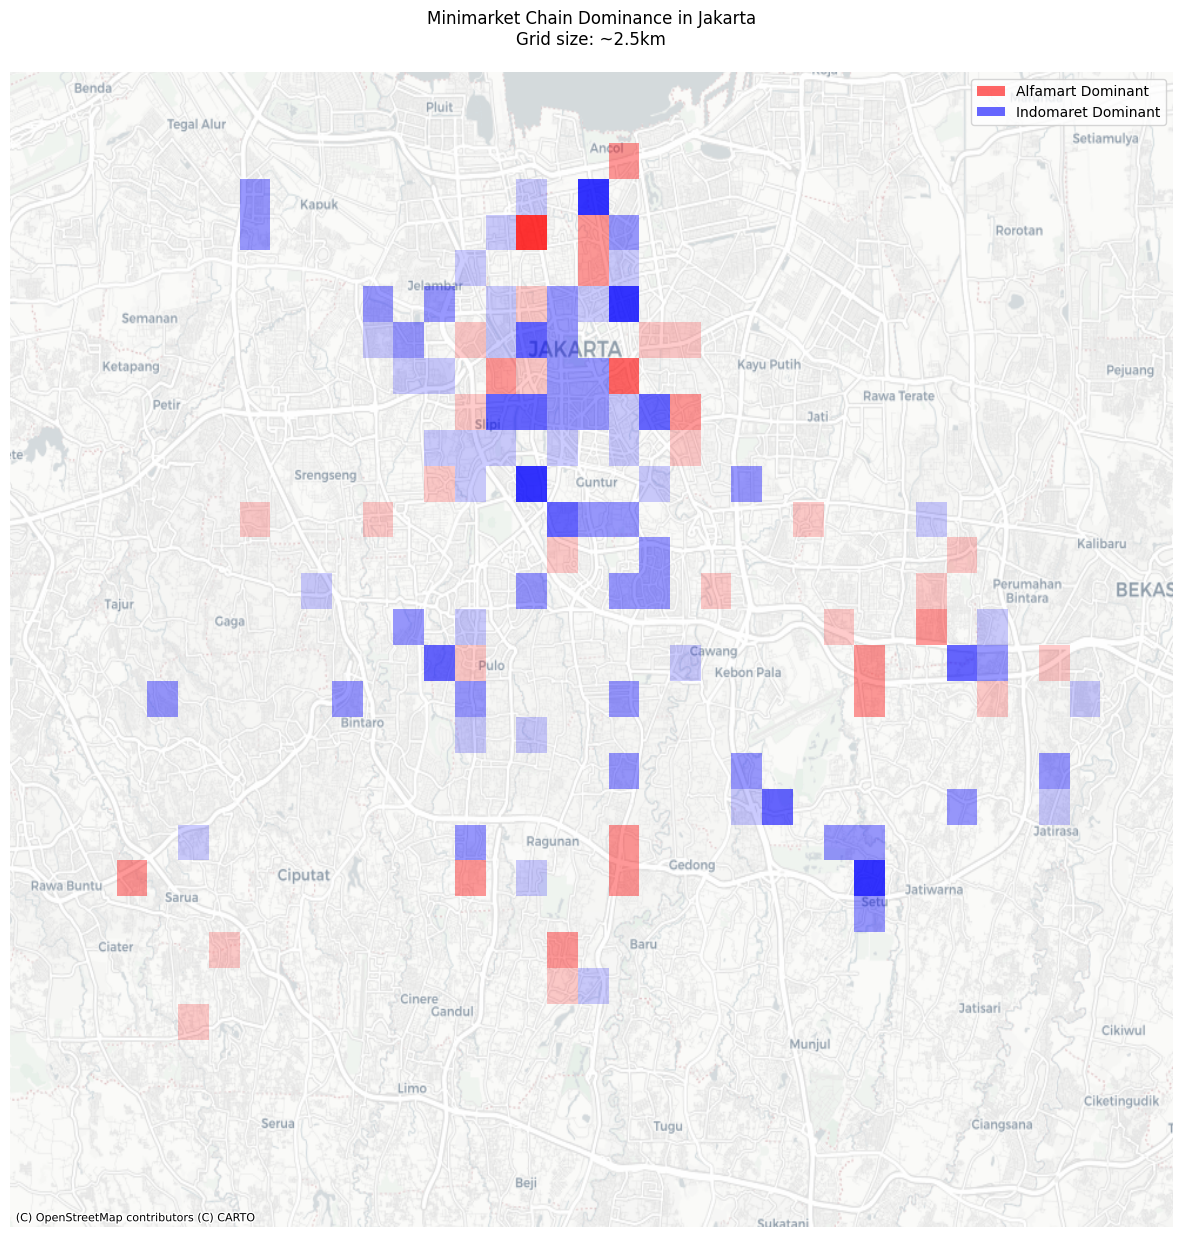

In [4]:
# Create a map using contextily and matplotlib
import contextily as ctx
import matplotlib.pyplot as plt

all_points_gdf = gpd.GeoDataFrame(all_points)
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Ensure data is in Web Mercator projection (EPSG:3857) for contextily
all_points_gdf = all_points_gdf.to_crs(epsg=3857)

# Calculate grid size for zoom level 11 (in meters since we're in Web Mercator)
grid_size = 1_000

# Group points into grid cells
all_points_gdf['grid_x'] = (all_points_gdf.geometry.x // grid_size) * grid_size
all_points_gdf['grid_y'] = (all_points_gdf.geometry.y // grid_size) * grid_size

# Count stores by type in each grid cell
grid_counts = all_points_gdf.groupby(['grid_x', 'grid_y', 'type']).size().unstack(fill_value=0)
grid_counts['dominant'] = grid_counts.idxmax(axis=1)
grid_counts['difference'] = abs(grid_counts['Alfamart'] - grid_counts['Indomaret'])

# Create rectangles for each grid cell
for idx, row in grid_counts.iterrows():
    grid_x, grid_y = idx
        
    # Color intensity based on dominance
    opacity = min(row['difference'] / 5, 0.8)  # Cap at 0.8 opacity
    
    # Red for Alfamart dominance, Blue for Indomaret
    color = 'red' if row['dominant'] == 'Alfamart' else 'blue'
    
    # Create rectangle
    rect = plt.Rectangle(
        (grid_x, grid_y), 
        grid_size, 
        grid_size,
        facecolor=color,
        alpha=opacity,
        edgecolor='none'
    )
    ax.add_patch(rect)

# Set map bounds to Jakarta area (converted to Web Mercator coordinates)
# Set bounds based on the data points with some padding
x_min = all_points_gdf.geometry.x.min()
x_max = all_points_gdf.geometry.x.max()
y_min = all_points_gdf.geometry.y.min() 
y_max = all_points_gdf.geometry.y.max()
x_padding = (x_max - x_min) * 0.1
y_padding = (y_max - y_min) * 0.1

ax.set_xlim([x_min - x_padding, x_max + x_padding])
ax.set_ylim([y_min - y_padding, y_max + y_padding])

ctx.add_basemap(
    ax, 
    source=ctx.providers.CartoDB.Positron,
    crs=all_points_gdf.crs
)

legend_elements = [
    plt.Rectangle((0,0), 1, 1, facecolor='red', alpha=0.6, label='Alfamart Dominant'),
    plt.Rectangle((0,0), 1, 1, facecolor='blue', alpha=0.6, label='Indomaret Dominant')
]
ax.legend(handles=legend_elements, loc='upper right')
ax.set_axis_off()

plt.title('Minimarket Chain Dominance in Jakarta\nGrid size: ~1km', pad=20)
plt.show()